<a href="https://colab.research.google.com/github/Meowmixforme/Kaggle_Machine_Learning_Projects/blob/main/Project%203%20Diabetes%20Risk%20Prediction/Diabetes_Risk_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Diabetes Risk Prediction

Author: James Fothergill

Import packages

In [75]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import cross_val_score, GridSearchCV


from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, RocCurveDisplay, accuracy_score

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

Import dataset

In [76]:
data = pd.read_csv('diabetes_data_upload.csv')

In [77]:
print(data.info())
print({column: data[column].unique() for column in data.columns})
print("\nMissing values:\n", data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Age                 520 non-null    int64 
 1   Gender              520 non-null    object
 2   Polyuria            520 non-null    object
 3   Polydipsia          520 non-null    object
 4   sudden weight loss  520 non-null    object
 5   weakness            520 non-null    object
 6   Polyphagia          520 non-null    object
 7   Genital thrush      520 non-null    object
 8   visual blurring     520 non-null    object
 9   Itching             520 non-null    object
 10  Irritability        520 non-null    object
 11  delayed healing     520 non-null    object
 12  partial paresis     520 non-null    object
 13  muscle stiffness    520 non-null    object
 14  Alopecia            520 non-null    object
 15  Obesity             520 non-null    object
 16  class               520 no

Preprocessing steps

In [78]:
{column: len(data[column].unique()) for column in data.columns}

{'Age': 51,
 'Gender': 2,
 'Polyuria': 2,
 'Polydipsia': 2,
 'sudden weight loss': 2,
 'weakness': 2,
 'Polyphagia': 2,
 'Genital thrush': 2,
 'visual blurring': 2,
 'Itching': 2,
 'Irritability': 2,
 'delayed healing': 2,
 'partial paresis': 2,
 'muscle stiffness': 2,
 'Alopecia': 2,
 'Obesity': 2,
 'class': 2}

In [79]:
def preprocess_inputs(df):
    df = df.copy()

    # Encode Gender
    df['Gender'] = df['Gender'].map({'Female': 0, 'Male': 1})
    # Encode all symptoms
    for col in df.columns.drop(['Age', 'Gender', 'class']):
        df[col] = df[col].map({'No': 0, 'Yes': 1})

    # Encode target
    le = LabelEncoder()
    df['class'] = le.fit_transform(df['class'])  # Positive=1, Negative=0

    # Split features/labels
    y = df['class']
    X = df.drop('class', axis=1)

    # Stratified split for balanced classes
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=0.7, stratify=y, shuffle=True, random_state=1
    )

    # Standardize features
    scaler = StandardScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

    return X_train, X_test, y_train, y_test, le

# Run preprocessing
X_train, X_test, y_train, y_test, le = preprocess_inputs(data)
print(X_train.head())
print(y_train.head())

          Age    Gender  Polyuria  Polydipsia  sudden weight loss  weakness  \
335  0.398811  0.772328 -0.989071   -0.905539           -0.818367  0.823055   
270 -0.657838 -1.294786  1.011050    1.104315            1.221945  0.823055   
140 -0.088873  0.772328  1.011050    1.104315           -0.818367 -1.214986   
264 -0.820399 -1.294786  1.011050    1.104315            1.221945  0.823055   
431 -0.495276  0.772328 -0.989071   -0.905539           -0.818367  0.823055   

     Polyphagia  Genital thrush  visual blurring   Itching  Irritability  \
335    1.098208       -0.530745         1.148247  0.989071     -0.547723   
270   -0.910574       -0.530745         1.148247 -1.011050     -0.547723   
140   -0.910574       -0.530745        -0.870893 -1.011050     -0.547723   
264    1.098208       -0.530745         1.148247  0.989071      1.825742   
431    1.098208       -0.530745        -0.870893 -1.011050      1.825742   

     delayed healing  partial paresis  muscle stiffness  Alopecia   

In [80]:
X_train

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity
335,0.398811,0.772328,-0.989071,-0.905539,-0.818367,0.823055,1.098208,-0.530745,1.148247,0.989071,-0.547723,1.068259,1.116653,1.279719,1.408406,-0.421893
270,-0.657838,-1.294786,1.011050,1.104315,1.221945,0.823055,-0.910574,-0.530745,1.148247,-1.011050,-0.547723,1.068259,1.116653,1.279719,-0.710023,-0.421893
140,-0.088873,0.772328,1.011050,1.104315,-0.818367,-1.214986,-0.910574,-0.530745,-0.870893,-1.011050,-0.547723,-0.936103,-0.895533,1.279719,-0.710023,-0.421893
264,-0.820399,-1.294786,1.011050,1.104315,1.221945,0.823055,1.098208,-0.530745,1.148247,0.989071,1.825742,1.068259,1.116653,1.279719,-0.710023,-0.421893
431,-0.495276,0.772328,-0.989071,-0.905539,-0.818367,0.823055,1.098208,-0.530745,-0.870893,-1.011050,1.825742,-0.936103,-0.895533,1.279719,-0.710023,-0.421893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,-0.007592,-1.294786,1.011050,1.104315,1.221945,0.823055,1.098208,-0.530745,1.148247,0.989071,1.825742,1.068259,1.116653,1.279719,-0.710023,-0.421893
11,-0.820399,0.772328,1.011050,1.104315,-0.818367,-1.214986,1.098208,1.884144,-0.870893,0.989071,-0.547723,1.068259,-0.895533,1.279719,-0.710023,-0.421893
30,0.723934,0.772328,1.011050,1.104315,1.221945,0.823055,1.098208,-0.530745,1.148247,-1.011050,-0.547723,-0.936103,1.116653,-0.781421,-0.710023,-0.421893
476,-0.413996,0.772328,-0.989071,-0.905539,-0.818367,0.823055,-0.910574,1.884144,-0.870893,0.989071,-0.547723,1.068259,-0.895533,-0.781421,1.408406,-0.421893


In [81]:
y_train

,class
335,0
270,1
140,1
264,1
431,1
...,...
164,1
11,1
30,1
476,0


Training

In [82]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "SVM (Linear Kernel)": LinearSVC(max_iter=10000),
    "SVM (RBF Kernel)": SVC(probability=True),
    "Neural Network": MLPClassifier(max_iter=500),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier()
}

In [83]:
for name, model in models.items():
    model.fit(X_train, y_train)
    print(f"{name} trained.")

Logistic Regression trained.
K-Nearest Neighbors trained.
Decision Tree trained.
SVM (Linear Kernel) trained.
SVM (RBF Kernel) trained.
Neural Network trained.
Random Forest trained.
Gradient Boosting trained.


Results

In [84]:
for name, model in models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"\n{name} Accuracy: {acc*100:.2f}%")
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))


Logistic Regression Accuracy: 94.87%
              precision    recall  f1-score   support

    Negative       0.93      0.93      0.93        60
    Positive       0.96      0.96      0.96        96

    accuracy                           0.95       156
   macro avg       0.95      0.95      0.95       156
weighted avg       0.95      0.95      0.95       156

Confusion Matrix:
[[56  4]
 [ 4 92]]

K-Nearest Neighbors Accuracy: 94.87%
              precision    recall  f1-score   support

    Negative       0.89      0.98      0.94        60
    Positive       0.99      0.93      0.96        96

    accuracy                           0.95       156
   macro avg       0.94      0.96      0.95       156
weighted avg       0.95      0.95      0.95       156

Confusion Matrix:
[[59  1]
 [ 7 89]]

Decision Tree Accuracy: 97.44%
              precision    recall  f1-score   support

    Negative       0.97      0.97      0.97        60
    Positive       0.98      0.98      0.98        96



Feature importance

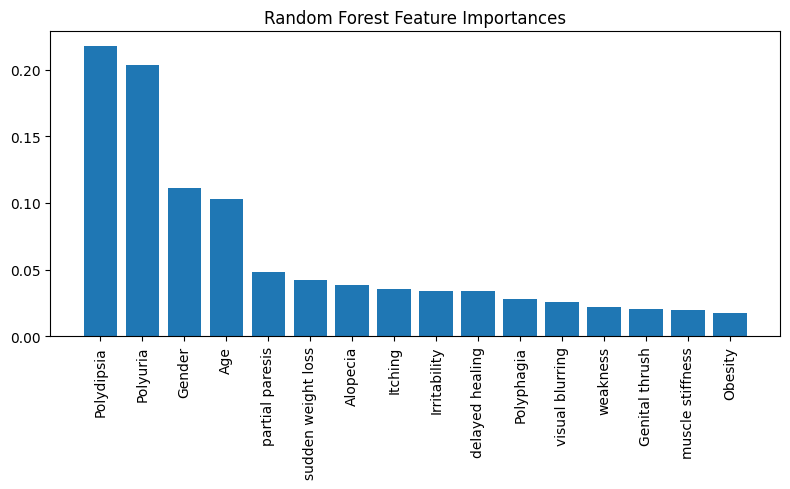

In [85]:
def plot_feature_importance(model, X_train, model_name):
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]
        plt.figure(figsize=(8,5))
        plt.title(f"{model_name} Feature Importances")
        plt.bar(range(X_train.shape[1]), importances[indices])
        plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
        plt.tight_layout()
        plt.show()
    elif hasattr(model, "coef_"):
        importances = np.abs(model.coef_[0])
        indices = np.argsort(importances)[::-1]
        plt.figure(figsize=(8,5))
        plt.title(f"{model_name} Coefficients")
        plt.bar(range(X_train.shape[1]), importances[indices])
        plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
        plt.tight_layout()
        plt.show()

# Example: Plot for Random Forest
plot_feature_importance(models["Random Forest"], X_train, "Random Forest")

ROC Curve

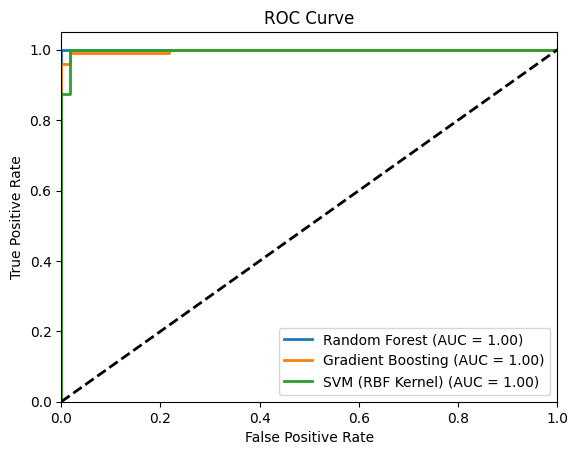

In [86]:
for name in ["Random Forest", "Gradient Boosting", "SVM (RBF Kernel)"]:
    model = models[name]
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
        # For LinearSVC use decision_function
        y_prob = model.decision_function(X_test)
        y_prob = (y_prob - y_prob.min())/(y_prob.max()-y_prob.min()) # scale to [0,1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

Cross-Validation

In [87]:
# Cross-validation
cv_scores = cross_val_score(RandomForestClassifier(), X_train, y_train, cv=5)
print("Random Forest CV accuracy: {:.2f}% +/- {:.2f}%".format(cv_scores.mean()*100, cv_scores.std()*100))

# Quick grid search example
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7, None]
}
grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best RF params:", grid.best_params_)
print("Best CV score: {:.2f}%".format(grid.best_score_ * 100))

Random Forest CV accuracy: 97.25% +/- 0.88%
Best RF params: {'max_depth': None, 'n_estimators': 50}
Best CV score: 97.80%
